# Adversarial Training on CIFAR-10 with FGSM attacks

In this notebook, we perform FGSM (targeted and non-targeted) attacks on the CIFAR-10 dataset using the Resnet18 model and build models to defend against these attacks using the Adversarial Training mechanism.

## Table of contents
*  **Preparing train and test data and building Resnet model**

    -  Training function

    -  Test function

    -  Trainig and test loss of Resnet18 model on Cifar-10


*  **FGSM**

    - Visualizing 10 selected samples from the dataset

    - FGSM attack function

    -  Creating adversarial examples from samples with the FGSM attack and eps = 1/255

    -  Adversarial Training with FGSM

    - Comparing naturally-trained and adversarially-trained models

    - Evaluating the adversarially-trained model with FGSM against FGSM attack on test data

    - Targeted FGSM


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# print(os.getcwd())


/content


In [ ]:
# desired_directory = '/content/drive/MyDrive/Submission-TUDresden-PratyushGarg' #change this to the location where 'resnet.py' file is located
# os.chdir(desired_directory)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *

import pickle


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

<a name='name'></a>
### Preparing train and test data and building Resnet model

In [ ]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..


### Training function

In [ ]:
def train(epoch, net):

    '''
    this function train net on training dataset
    '''

    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

### Test function

In [ ]:
def test(epoch, net):

    '''
    This function evaluate net on test dataset
    '''

    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss/len(testloader)

In [9]:
train_losses=[]
test_losses=[]
epochs=30

for epoch in range(0,epochs):
    train_losses.append(train(epoch, net))
    test_losses.append(test(epoch, net))
    scheduler.step()
    print(epoch)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [10]:
print('Accuracy of the network on the test images: %d %%' % (acc))

Accuracy of the network on the test images: 87 %


####Training and test loss of Resnet18 model on Cifar-10

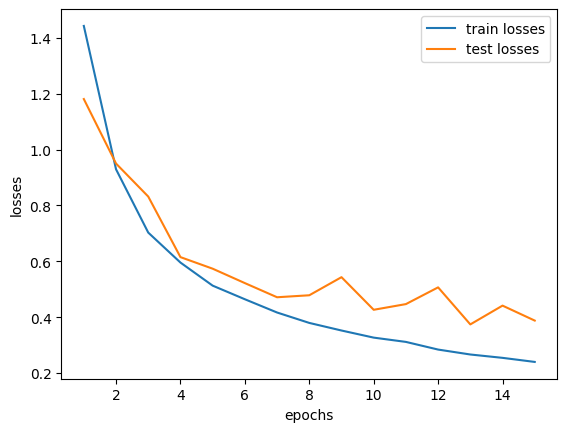

In [11]:
epochs=15
plt.plot(np.arange(1,epochs+1),train_losses, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [ ]:
# Save the model parameters
torch.save(net.state_dict(), 'resnet18_cifar10.pth')

## FGSM

### Visualizing 10 selected samples from the dataset

We need these samples later to make adversarial examples.

In [12]:
imgloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
dataiter = iter(imgloader)
org_images, org_labels = next(dataiter)

In [13]:
org_labels = org_labels.to(device)
org_images = org_images.to(device)
print(org_images.shape)
outputs= net(org_images)
output=outputs.to(device)
print(outputs.shape)
_, predicted = torch.max(outputs.data, 1)


torch.Size([100, 3, 32, 32])
torch.Size([100, 10])


In [14]:
print(outputs)

tensor([[-1.6013e+00,  4.1405e-01, -3.0315e+00,  7.2672e+00, -6.8399e-01,
          6.1694e+00,  6.5238e-01, -9.4150e-01, -5.1545e+00, -4.2905e+00],
        [ 7.1074e+00,  7.5254e+00, -7.9249e+00, -4.8680e+00, -5.4501e+00,
         -7.8273e+00, -6.3411e+00, -3.5584e+00,  1.9405e+01, -1.4468e+00],
        [ 5.4693e+00,  7.1177e+00, -5.3254e+00, -5.1984e+00, -3.3533e+00,
         -6.4650e+00, -7.4227e+00, -1.8792e+00,  1.3720e+01,  1.0023e+00],
        [ 7.8938e+00, -5.4703e-01, -1.7368e+00, -2.4541e-01, -4.3472e+00,
         -4.4387e+00, -5.3396e+00, -2.5026e+00,  5.8210e+00,  3.2829e+00],
        [-2.9202e+00, -2.2493e+00,  4.4552e+00,  1.6899e+00,  1.6349e+00,
         -1.7194e+00,  1.2294e+01, -5.9836e+00, -4.3141e+00, -2.9503e+00],
        [-5.3549e+00, -3.5985e+00,  1.1536e-01,  3.6933e+00,  6.4653e-01,
          4.6236e+00,  1.4023e+01, -4.0236e+00, -5.6518e+00, -4.7964e+00],
        [-1.9847e+00,  1.3110e+01, -2.8382e+00, -7.9052e-02, -5.0502e+00,
         -1.1520e+00, -4.6275e+0

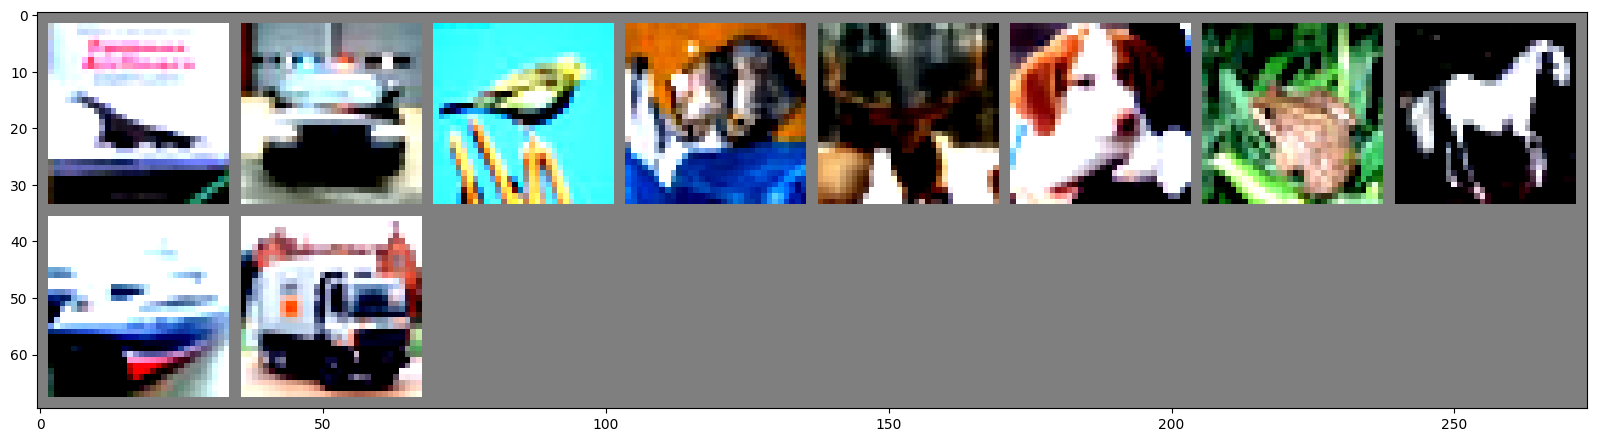

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
tensor([[ 7.8938, -0.5470, -1.7368, -0.2454, -4.3472, -4.4387, -5.3396, -2.5026,
          5.8210,  3.2829],
        [ 1.8048,  8.5632, -6.1656, -2.3476, -2.7848, -4.6791, -5.0660, -3.3551,
          8.7245,  3.2867],
        [ 2.0267,  4.1233, 11.1620, -2.4352, -3.6367, -5.1544, -0.0211, -1.8633,
         -3.9760,  0.1025],
        [-1.6013,  0.4141, -3.0315,  7.2672, -0.6840,  6.1694,  0.6524, -0.9415,
         -5.1545, -4.2905],
        [-4.9043, -5.2839,  4.1031,  3.5543,  9.2084,  2.5184,  2.3057, -0.2185,
         -6.8264, -4.2773],
        [-3.6682, -3.6322, -2.1982,  4.4196, -2.9050, 10.9964, -1.3955,  6.9821,
         -5.7464, -4.4368],
        [-2.9202, -2.2493,  4.4552,  1.6899,  1.6349, -1.7194, 12.2936, -5.9836,
         -4.3141, -2.9503],
        [-4.3508,  0.0342,  0.0478, -0.8104,  1.3863,  2.4398, -2.5911, 14.7562,
         -7.1036, -3.8796],
        [ 7.1074,  7.5254, -7.9249, -4.8680, -5.4501, -7.8273, -6.3411, 

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


samples = []
samples_labels = []
samples_pred = []
selected = [3,66,67,0,26,16,4,13,1,11]

for i in selected:
  samples.append(org_images[i])
  samples_labels.append(org_labels[i])
  samples_pred.append(outputs[i])
samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)
imshow(torchvision.utils.make_grid(samples.cpu()))
print(samples_labels)
print(samples_pred)

###FGSM attack function
In the FGSM attack, we make adversarial examples using this equation:
$x_{adv}=x_{benign}+\epsilon * sign(\nabla_{x_{benign}}l(\theta, x, y))$

In [16]:
def FGSM(net, x, y, eps):
        '''
        inputs:
            net: the network through which we pass the inputs
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            eps: perturbation budget

        outputs:
            x_adv : the adversarial example constructed from x
            h_adv: output of the last softmax layer when applying net on x_adv
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''

        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()

        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert


### Creating adversarial examples from samples with the FGSM attack and eps = 1/255


from left to right: (1/eps) perturbation, original image, adversarial example



true label: 0 adversary label: 8


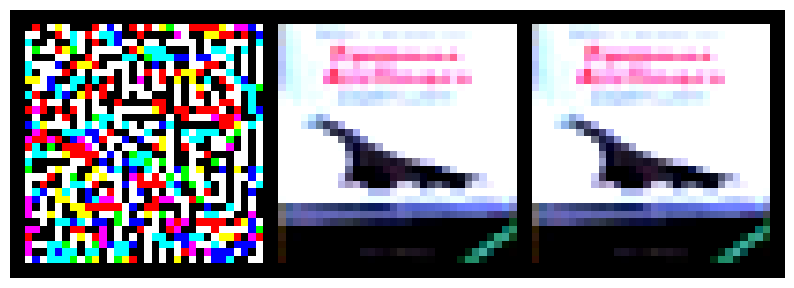

true label: 1 adversary label: 8


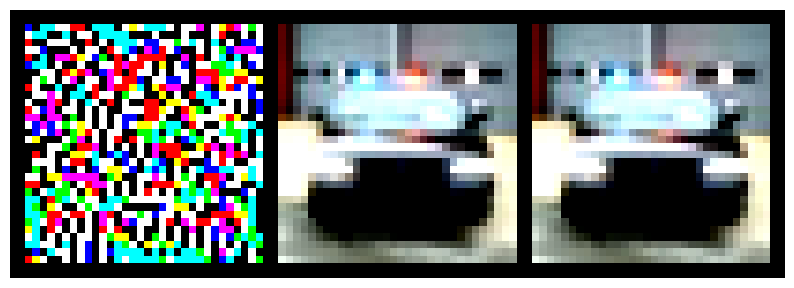

true label: 2 adversary label: 1


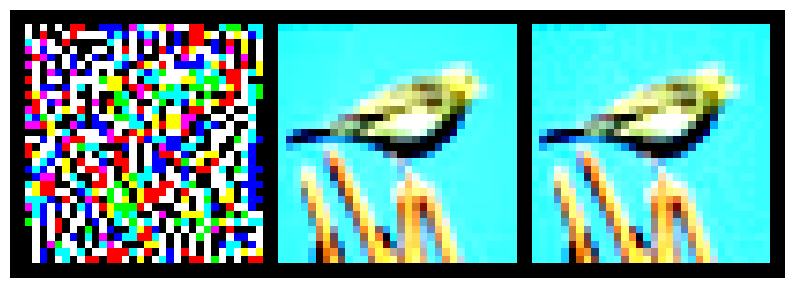

true label: 3 adversary label: 5


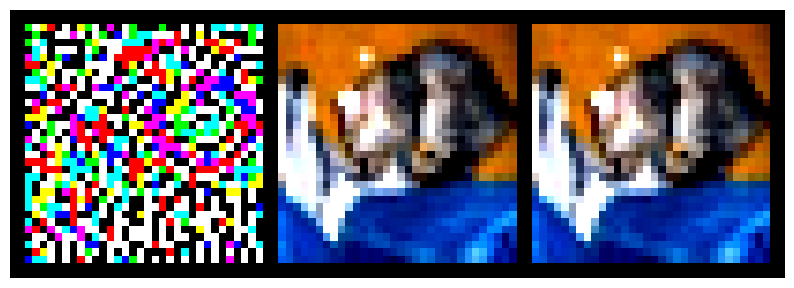

true label: 4 adversary label: 2


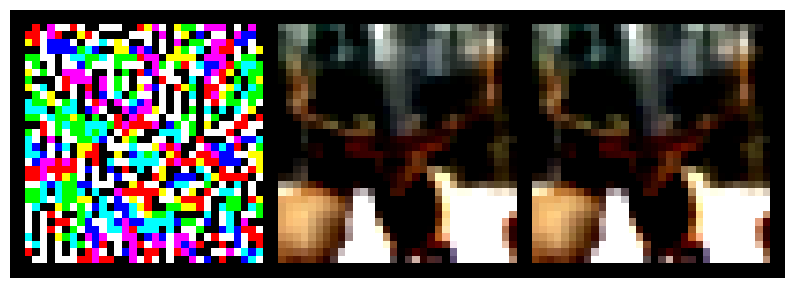

true label: 5 adversary label: 7


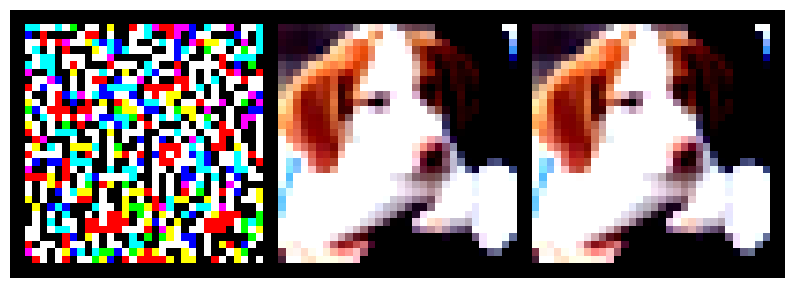

true label: 6 adversary label: 2


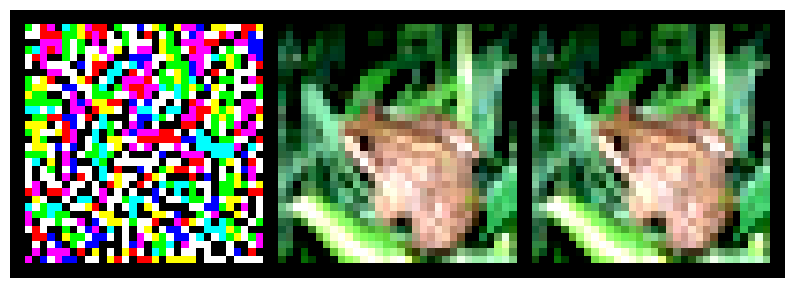

true label: 7 adversary label: 5


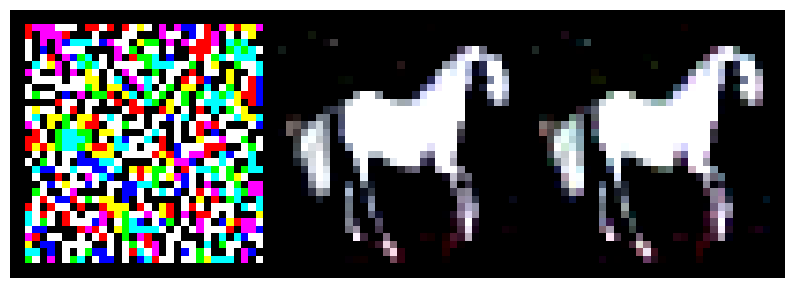

true label: 8 adversary label: 1


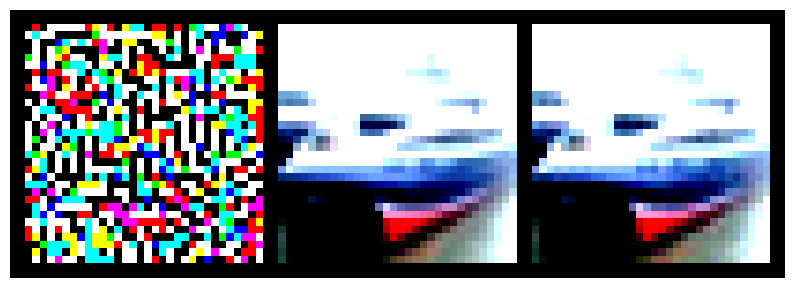

true label: 9 adversary label: 1


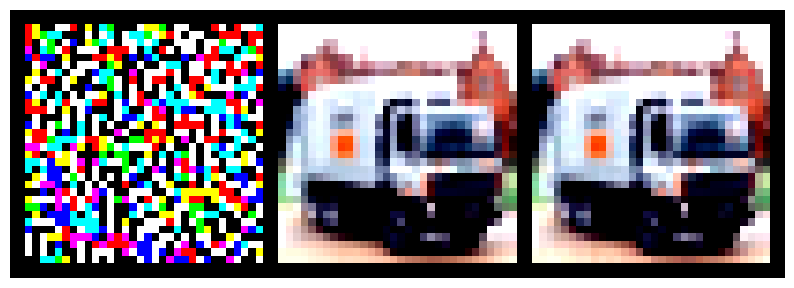

In [17]:
print()
print('from left to right: (1/eps) perturbation, original image, adversarial example')
print()
for i in selected:
    eps=1/255
    while True:
        x_adv, h_adv, y_adv, pert=FGSM(net, org_images[i].unsqueeze_(0),org_labels[i].unsqueeze_(0),eps)
        if y_adv.item()==org_labels[i].item():
            eps=eps+(1/255)
        else:
            break
    print("true label:", org_labels[i].item(), "adversary label:", y_adv.item())
    triple=[]
    with torch.no_grad():
        triple.append((1/eps)*pert.detach().clone().squeeze_(0))
        triple.append(org_images[i])
        triple.append(x_adv.detach().clone().squeeze_(0))
        triple=torch.stack(triple)
        grid = torchvision.utils.make_grid(triple.cpu()/2+0.5)
        plt.figure(figsize=(10,10))
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()



**As you can see, the original and adversarial examples look extremely similar to the human eye.**

### Adversarial Training with FGSM

First, we should build a new model (which we call net_adv) to train on adversarial examples generated by the FGSM attack.

In [18]:
print('==> Building new model..')
net_adv = ResNet18()
net_adv = net_adv.to(device)
if device == 'cuda':
    net_adv = torch.nn.DataParallel(net_adv)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_adv = optim.SGD(net_adv.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=200)


==> Building new model..


Train_adv function trains a given neural network on adversarial examples generated from training data using the FGSM attack.



In [19]:
def train_adv(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)

        cost = criterion(h_, targets)

        net.zero_grad()
        cost.backward()

        pert= eps*inputs_.grad.detach().sign()
        x_adv = inputs_ + pert

        optimizer_adv.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

In [20]:
# train_losses_adv=[]
# test_losses_adv=[]
# epochs=15

# for epoch in range(0,epochs):
#     train_losses_adv.append(train_adv(epoch, net_adv))
#     test_losses_adv.append(test(epoch, net_adv))
#     scheduler_adv.step()
#     print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [21]:
# print('Accuracy of the network on unperturbed test images: %d %%' % (acc))

Accuracy of the network on unperturbed test images: 83 %


#### Comparing naturally-trained and adversarially-trained models

Train - natural: training loss of the naturally-trained model

Train - adversary: training loss of the adversarially-trained model

Test - natural:  loss of the naturally-trained model on original (unperturbed) test images

Test - adversary: loss of the adversarially-trained model on original (unperturbed) test images

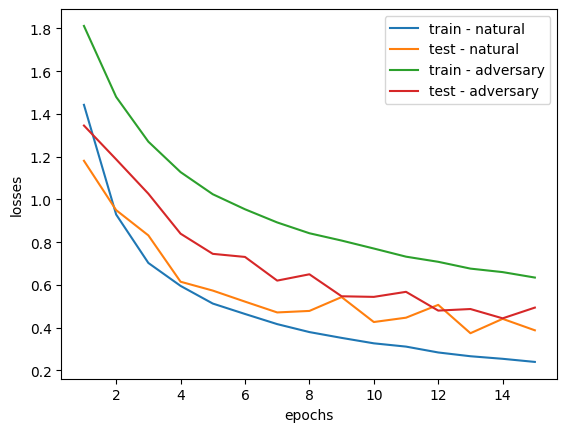

In [22]:
# plt.plot(np.arange(1,epochs+1),train_losses, label='train - natural')
# plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
# plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary')
# plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary')
# plt.xlabel('epochs')
# plt.ylabel('losses')
# plt.legend()
# plt.show()

Training losses of the adversarially-trained model are higher than training losses of the naturally-trained model, which is intuitive since the adversarially-trained model is trained against adversarial examples, which makes it harder for the model to label these perturbed inputs correctly and results in higher errors.

The loss of the naturally-trained model on test data is higher than the training loss, since test data is unseen by the model, resulting in higher error in classification.

However, the loss of the adversarially-trained model on test data is lower than the corresponding training loss. This is probably because the test instances are not adversarial (in contrast to training data) and that the model has learned to extract important and useful features, thus performing better on test images.

####Evaluating the adversarially-trained model with FGSM against FGSM attack on test data


Test_adv function constructs adversarial examples from test data (with FGSM using net) and evaluates net_adv on them.

In [23]:
def test_adv(net, net_adv, eps):
    accuracy=0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM (net, inputs, targets, eps)

        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [24]:
net2 = net
net3 = net
accuracy = test_adv(net, net2, eps)
print("accuracy of normal network (without adversarial training) on adversarially attacked dataset: ", accuracy)

accuracy of normal network (without adversarial training) on adversarially attacked dataset:  31.94


In [25]:
# for eps in [4/355, 8/255, 12/255]:
#     accuracy=test_adv(net, net_adv, eps)
#     print("epsilon:", eps, "accuracy:", accuracy)

epsilon: 0.011267605633802818 accuracy: 82.81
epsilon: 0.03137254901960784 accuracy: 81.71
epsilon: 0.047058823529411764 accuracy: 80.92


PGD Training

In [26]:
# PGD Attack
# MNIST init
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    ori_images = images.data

    for i in range(iters) :
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images

In [27]:
def train_adv_pgd(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        
        # h_ = net(inputs_)

        # cost = criterion(h_, targets)

        # net.zero_grad()
        # cost.backward()

        # pert= eps*inputs_.grad.detach().sign()
        # x_adv = inputs_ + pert



        optimizer_adv.zero_grad()
        pgd_attacked_imgs = pgd_attack(net, inputs_, targets)
        outputs = net(pgd_attacked_imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print("train loss: ", train_loss/len(trainloader))
    return train_loss/len(trainloader)

In [ ]:
def test_adv(net, net_adv, eps):
    accuracy=0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM (net, inputs, targets, eps)

        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    print(accuracy)

In [28]:
print('==> Building new model..')
net_adv2 = ResNet18()
net_adv2 = net_adv2.to(device)
if device == 'cuda':
    net_adv2 = torch.nn.DataParallel(net_adv2)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_adv2 = optim.SGD(net_adv.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_adv2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv2, T_max=200)


==> Building new model..


In [ ]:
train_losses_adv=[]
test_losses_adv=[]
epochs=50

for epoch in range(0,epochs):
    train_losses_adv.append(train_adv_pgd(epoch, net_adv2))
    test_adv(net, net_adv2, 8/255)
    scheduler_adv.step()
    print("epoch: ", epoch)

0
1
2
3
4
5
6


In [ ]:
# Save the model parameters
torch.save(net_adv2.state_dict(), 'resnet18_pgdTrained_CIFAR10.pth')

In [ ]:
# plt.plot(np.arange(1,epochs+1),train_losses, label='train - natural')
# plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
# plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary')
# plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary')
# plt.xlabel('epochs')
# plt.ylabel('losses')
# plt.legend()
# plt.show()

In [ ]:
# print('Accuracy of the network on unperturbed test images: %d %%' % (acc))

In [ ]:
# for eps in [4/355, 8/255, 12/255]:
#     accuracy=test_adv(net3, net_adv2, eps)
#     print("epsilon:", eps, "accuracy:", accuracy)

We see that **as epsilon increases, the accuracy decreases**, since for bigger epsilons, greater perturbations are allowed, therefore it becomes harder for the model to correctly label those perturbed examples.